# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [ ]:
DATA_FOLDER = '' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [ ]:
# Write your answer here

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [ ]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [3]:
from IPython.core.display import HTML
HTML('Data/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Import libraries

In [2]:
from IPython.core.display import HTML
import pandas as pd
%pylab inline
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copyi2ng a slice from a DataFrame.

Populating the interactive namespace from numpy and matplotlib


## Read file

In [3]:
data = pd.read_excel('Data/titanic.xls')
data.head(10)# data = pd.read_table('Data/titanic.xls')

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


## 2. Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.

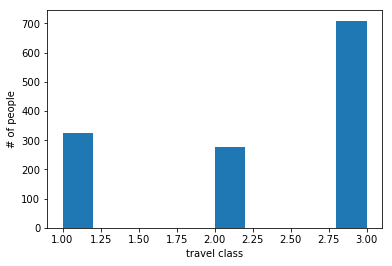

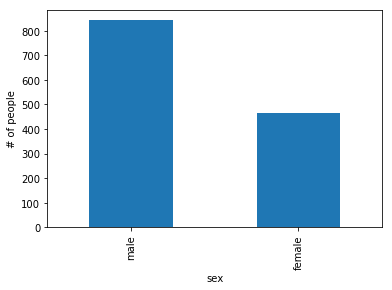

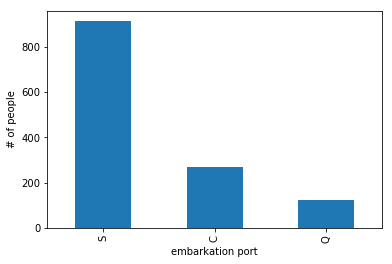

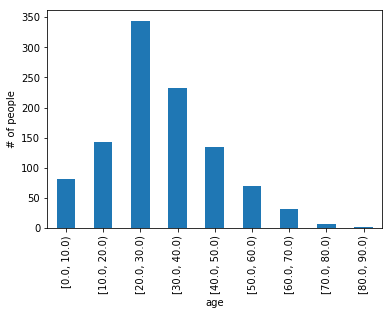

In [43]:
def plot_fig(series, kind, label_x = '', label_y = '', title_ = ''):
    figure()
    series.plot(kind = kind)
    xlabel(label_x)
    ylabel(label_y)
    title(title_)
    
# travel class
plot_fig(data.pclass, kind = 'hist', label_x = 'travel class', label_y = '# of people')

# sex, string cannot be made in histogram, and hence using bar plot
plot_fig(data.sex.value_counts(), 'bar', label_x = 'sex', label_y = '# of people')

# embarkation port
plot_fig(data.embarked.value_counts(), 'bar', label_x = 'embarkation port', label_y = '# of people')

# age (10 years as an interval)
figure()
data_age = data.age.copy()
bin_range = np.arange(0,data_age.max() + 20,10)
out, bins  = pd.cut(data.age, bins=bin_range, include_lowest=True, right=False, retbins=True)
plot_fig(out.value_counts(sort=False), 'bar', label_x = 'age', label_y = '# of people')

## 3. Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.

In [48]:
def plot_pie(series, label_x = '', label_y = '', title_ = ''):
    figure()
    series.plot.pie(autopct='%1.1f%%')
    xlabel(label_x)
    ylabel(label_y)
    title(title_)

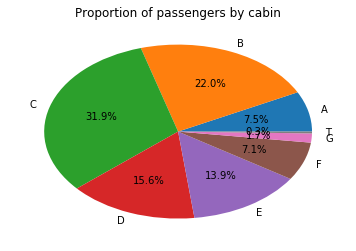

In [50]:
survive_stat = pd.crosstab(data.cabin, data.survived) 
survive_stat = survive_stat.rename_axis(lambda x: x[0]) # first letter -> floor
survive_stat = survive_stat.groupby(survive_stat.index).sum()
survive_stat['people'] = survive_stat[0] + survive_stat[1]

plot_pie(survive_stat['people'], title_ = 'Proportion of passengers by cabin')


## 4. For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

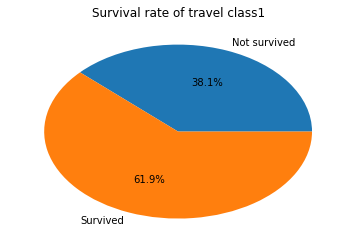

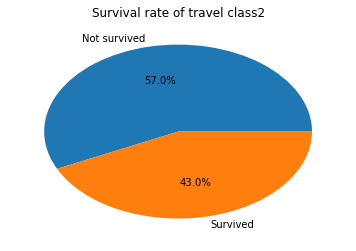

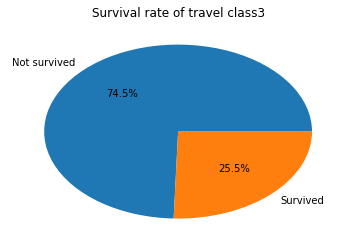

In [52]:
# generate the dataframe: survive v.s. class
survive_stat = pd.crosstab(data.survived, data.pclass)

# change the value of index
survive_stat = survive_stat.rename_axis({0: 'Not survived', 1: 'Survived'}) 

for class_no in survive_stat.columns:
    plot_pie(survive_stat[class_no], title_ = 'Survival rate of travel class' + str(class_no))


## 5. Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

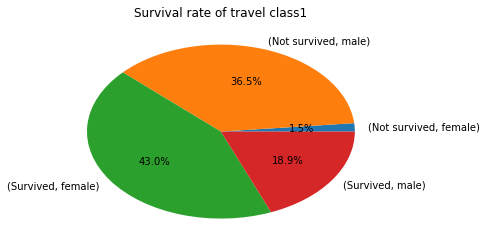

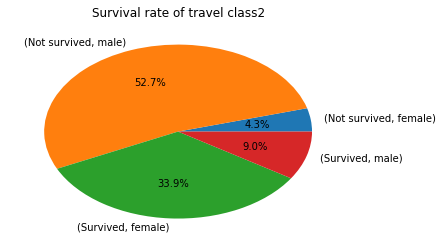

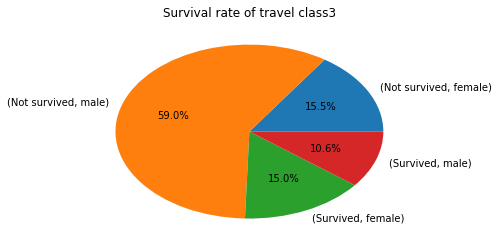

In [55]:
# generate the dataframe: (survive,sex) v.s. class
survive_stat = pd.crosstab([data.survived, data.sex], data.pclass)

# change the value of index
survive_stat = survive_stat.rename_axis({0: 'Not survived', 1: 'Survived'})

for class_no in survive_stat.columns:
    plot_pie(survive_stat[class_no], title_ = 'Survival rate of travel class' + str(class_no))

## 6. Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.